# 数据收集部分

In [27]:
def extract_article(driver):
    '''
    使用dfs遍历当前节点中的所有文本内容，防止中间格式发生变化。
    传入：selenium对象
    '''
    from bs4 import BeautifulSoup
    # 下面开始解析页面
    bs = BeautifulSoup(driver.page_source, 'lxml')
    # 我们最好的到render-detail-article-content中的所有内容, 之后遍历其中, 将所有的标签内容全部找出来

    label = bs.find('div', {'class':'render-detail-article-content'})
    # 现在我们要遍历这个玩意
    article_set = []
    def _extract_article(label):
        from bs4 import NavigableString
        # 遍历当前标签中的所有子节点
        for child in label:
            # 如果当前节点是文本，则将其记录；否则递归进入
            if type(child) == NavigableString:
                article_set.append(child)
            else:
                _extract_article(child)
    if label:
        _extract_article(label)
    return article_set

from selenium import webdriver
import time

# 人民眼中的习总书记
# URL = 'https://www.xuexi.cn/71a472c6203e03e49df7768d4d01ba31/b78fdcf1d588904b1965faf807264e6f.html'
# 世界眼中的习总书记
URL = 'https://www.xuexi.cn/3960624581d7231cef96ba3ca43ec77c/d0fd85813f78b23f5e5399baa4304972.html'
driver = webdriver.Chrome()
driver.get(URL)

from selenium.webdriver.common.by import By

# 现在我们要等待加载完成
from selenium.common.exceptions import NoSuchElementException


def is_ele_exist(text):
    '''
    判断元素是否存在，如果不存在则阻塞（等待页面加载完毕）
    '''
    try:
        driver.find_element_by_xpath(f"//*[text()='{text}']")
    except NoSuchElementException:
        return False
    return True

def click_ele_by_text(text):
    '''
    通过任意文本找到元素并点击
    '''
    driver.find_element_by_xpath(f"//*[text()='{text}']").click()

articles = []

# 要爬取页面的数量
cnt = 200
    
while cnt:
    # 这里使用等待方法将元素获取到
    from selenium.webdriver.support.ui import WebDriverWait
    from selenium.webdriver.support import expected_conditions as EC
    link_list = WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.XPATH, "/html/body/div/div/div/section/div/div/div/div/div[2]/section/div/div/div/div/div/section/div/div/div/div[1]/div/section/div/div/div/div/div/section/div/div/div/div/div/section/div/div/div/div/div/section/div/div/div/div/div[2]/section/div/div/div[1]/div/div[*]/div/div/div[1]")))
    # 在这里处理得到的列表
    for link_item in link_list:
        link_item.click()
        # 开始处理文本内容 别忘了等待页面加载完成
        driver.switch_to.window(driver.window_handles[-1])
        # time.sleep(2)
        # 现在我们将所有的文本提取出来 从当前页面处理就行
        articles.extend(extract_article(driver))
        # time.sleep(1)
        # 之后关闭新打开的标签页
        driver.close()
        driver.switch_to.window(driver.window_handles[0])
        
        cnt -= 1
        if not cnt:
            break
            
    link_list[0].click()
    print('换页了' + f'当前容量{len(articles)}')
    # 手动翻页
    if is_ele_exist('>>'):
        click_ele_by_text('>>')
    else:
        break


换页了当前容量390
换页了当前容量722
换页了当前容量1015
换页了当前容量1342
换页了当前容量1622
换页了当前容量1907
换页了当前容量2267
换页了当前容量2632
换页了当前容量2911
换页了当前容量3165


In [28]:
driver.quit()

# 数据清洗

## 去除括号内内容

In [29]:
import re

In [30]:
# 一定要有数据清洗的过程
def remove_bracket(str_list):
    '''
    (记者: xxx)使用正则表达式去掉括号和其中的内容
    传入：文本序列
    '''
    pattern = re.compile(u"\\（.*?）")
    return [ pattern.sub('', line) for line in str_list ]

# 测试
# li = ['这里有（这里没有）这里有', '这里有这里有']
# print(remove_bracket(li))

## 短内容删除

In [31]:
def remove_comma(str_list):
    '''
    删除冒号结尾的内容
    传入：文本序列
    '''
    return [ line for line in str_list if len(line) and line[-1] != '：' ]

# print(remove_comma(['abaaba：', 'dafdsfdffd', 'fdsaf：fdsf']))

## 去掉空格(最后的摄影作者)和空行

In [32]:
def remove_spaces(str_list):
    '''
    现在我们要把分割出来的部分中最长的都拿出来
    传入：文本序列
    '''
    return [ sorted(line.split(' '), key=len, reverse=True)[0] for line in str_list if len(line)]

# print(remove_spaces(['新华社北京10月11日电 “年轻干部要起而行之、勇挑重担，积极投身新时代中国特色社会主义伟大实践，经风雨、见世面，真刀真枪锤炼能力，以过硬本领展现作为、不辱使命。”', ' dafdsfd ffd', 'fdsaf fdsf', '']))

In [33]:
def remove_markers(str_list):
    '''
    删除句子中的标点符号
    传入：文本序列
    '''
    pattern = re.compile(r'[^0-9A-Za-z\u4e00-\u9fa5]')
    return [pattern.sub('', line) for line in str_list]

# print(remove_markers(['新华社北京10月11日电 “年轻干部要起而行之、勇挑重担，积极投身新时代中国特色社会主义伟大实践，经风雨、见世面，真刀真枪锤炼能力，以过硬本领展现作为、不辱使命。”']))

In [34]:
# 将上面所有的东西集成清洗一下
articles = remove_markers(remove_spaces(remove_comma(remove_bracket(articles))))

## 分词

下面是jieba库中的词性说明

| 标签 | 含义     | 标签 | 含义     | 标签 | 含义     | 标签 | 含义     |
| ---- | -------- | ---- | -------- | ---- | -------- | ---- | -------- |
| n    | 普通名词 | f    | 方位名词 | s    | 处所名词 | t    | 时间     |
| nr   | 人名     | ns   | 地名     | nt   | 机构名   | nw   | 作品名   |
| nz   | 其他专名 | v    | 普通动词 | vd   | 动副词   | vn   | 名动词   |
| a    | 形容词   | ad   | 副形词   | an   | 名形词   | d    | 副词     |
| m    | 数量词   | q    | 量词     | r    | 代词     | p    | 介词     |
| c    | 连词     | u    | 助词     | xc   | 其他虚词 | w    | 标点符号 |
| PER  | 人名     | LOC  | 地名     | ORG  | 机构名   | TIME | 时间     |

In [35]:
import jieba
import jieba.posseg as pseg

'''
现在使用jieba库将articles变成词组
我们提取了 形容词、动词、副词、动副词、普通名词
'''
words_list = []
for line in articles:
    words_list.extend( word for word, flag in pseg.cut(line, use_paddle=True) if flag in ['a', 'v', 'd', 'vd', 'n'] )

## 再次清洗(排除无关的词)

In [36]:
'''
去掉图片中与主题无关的词
'''
bad_words = [
    '广大',
    '总书记',
    '进一步',
    '座谈会',
    '社会主义',
    '党委书记',
    '越来越',
]

## 数据可视化

Populating the interactive namespace from numpy and matplotlib


(-0.5, 959.5, 979.5, -0.5)

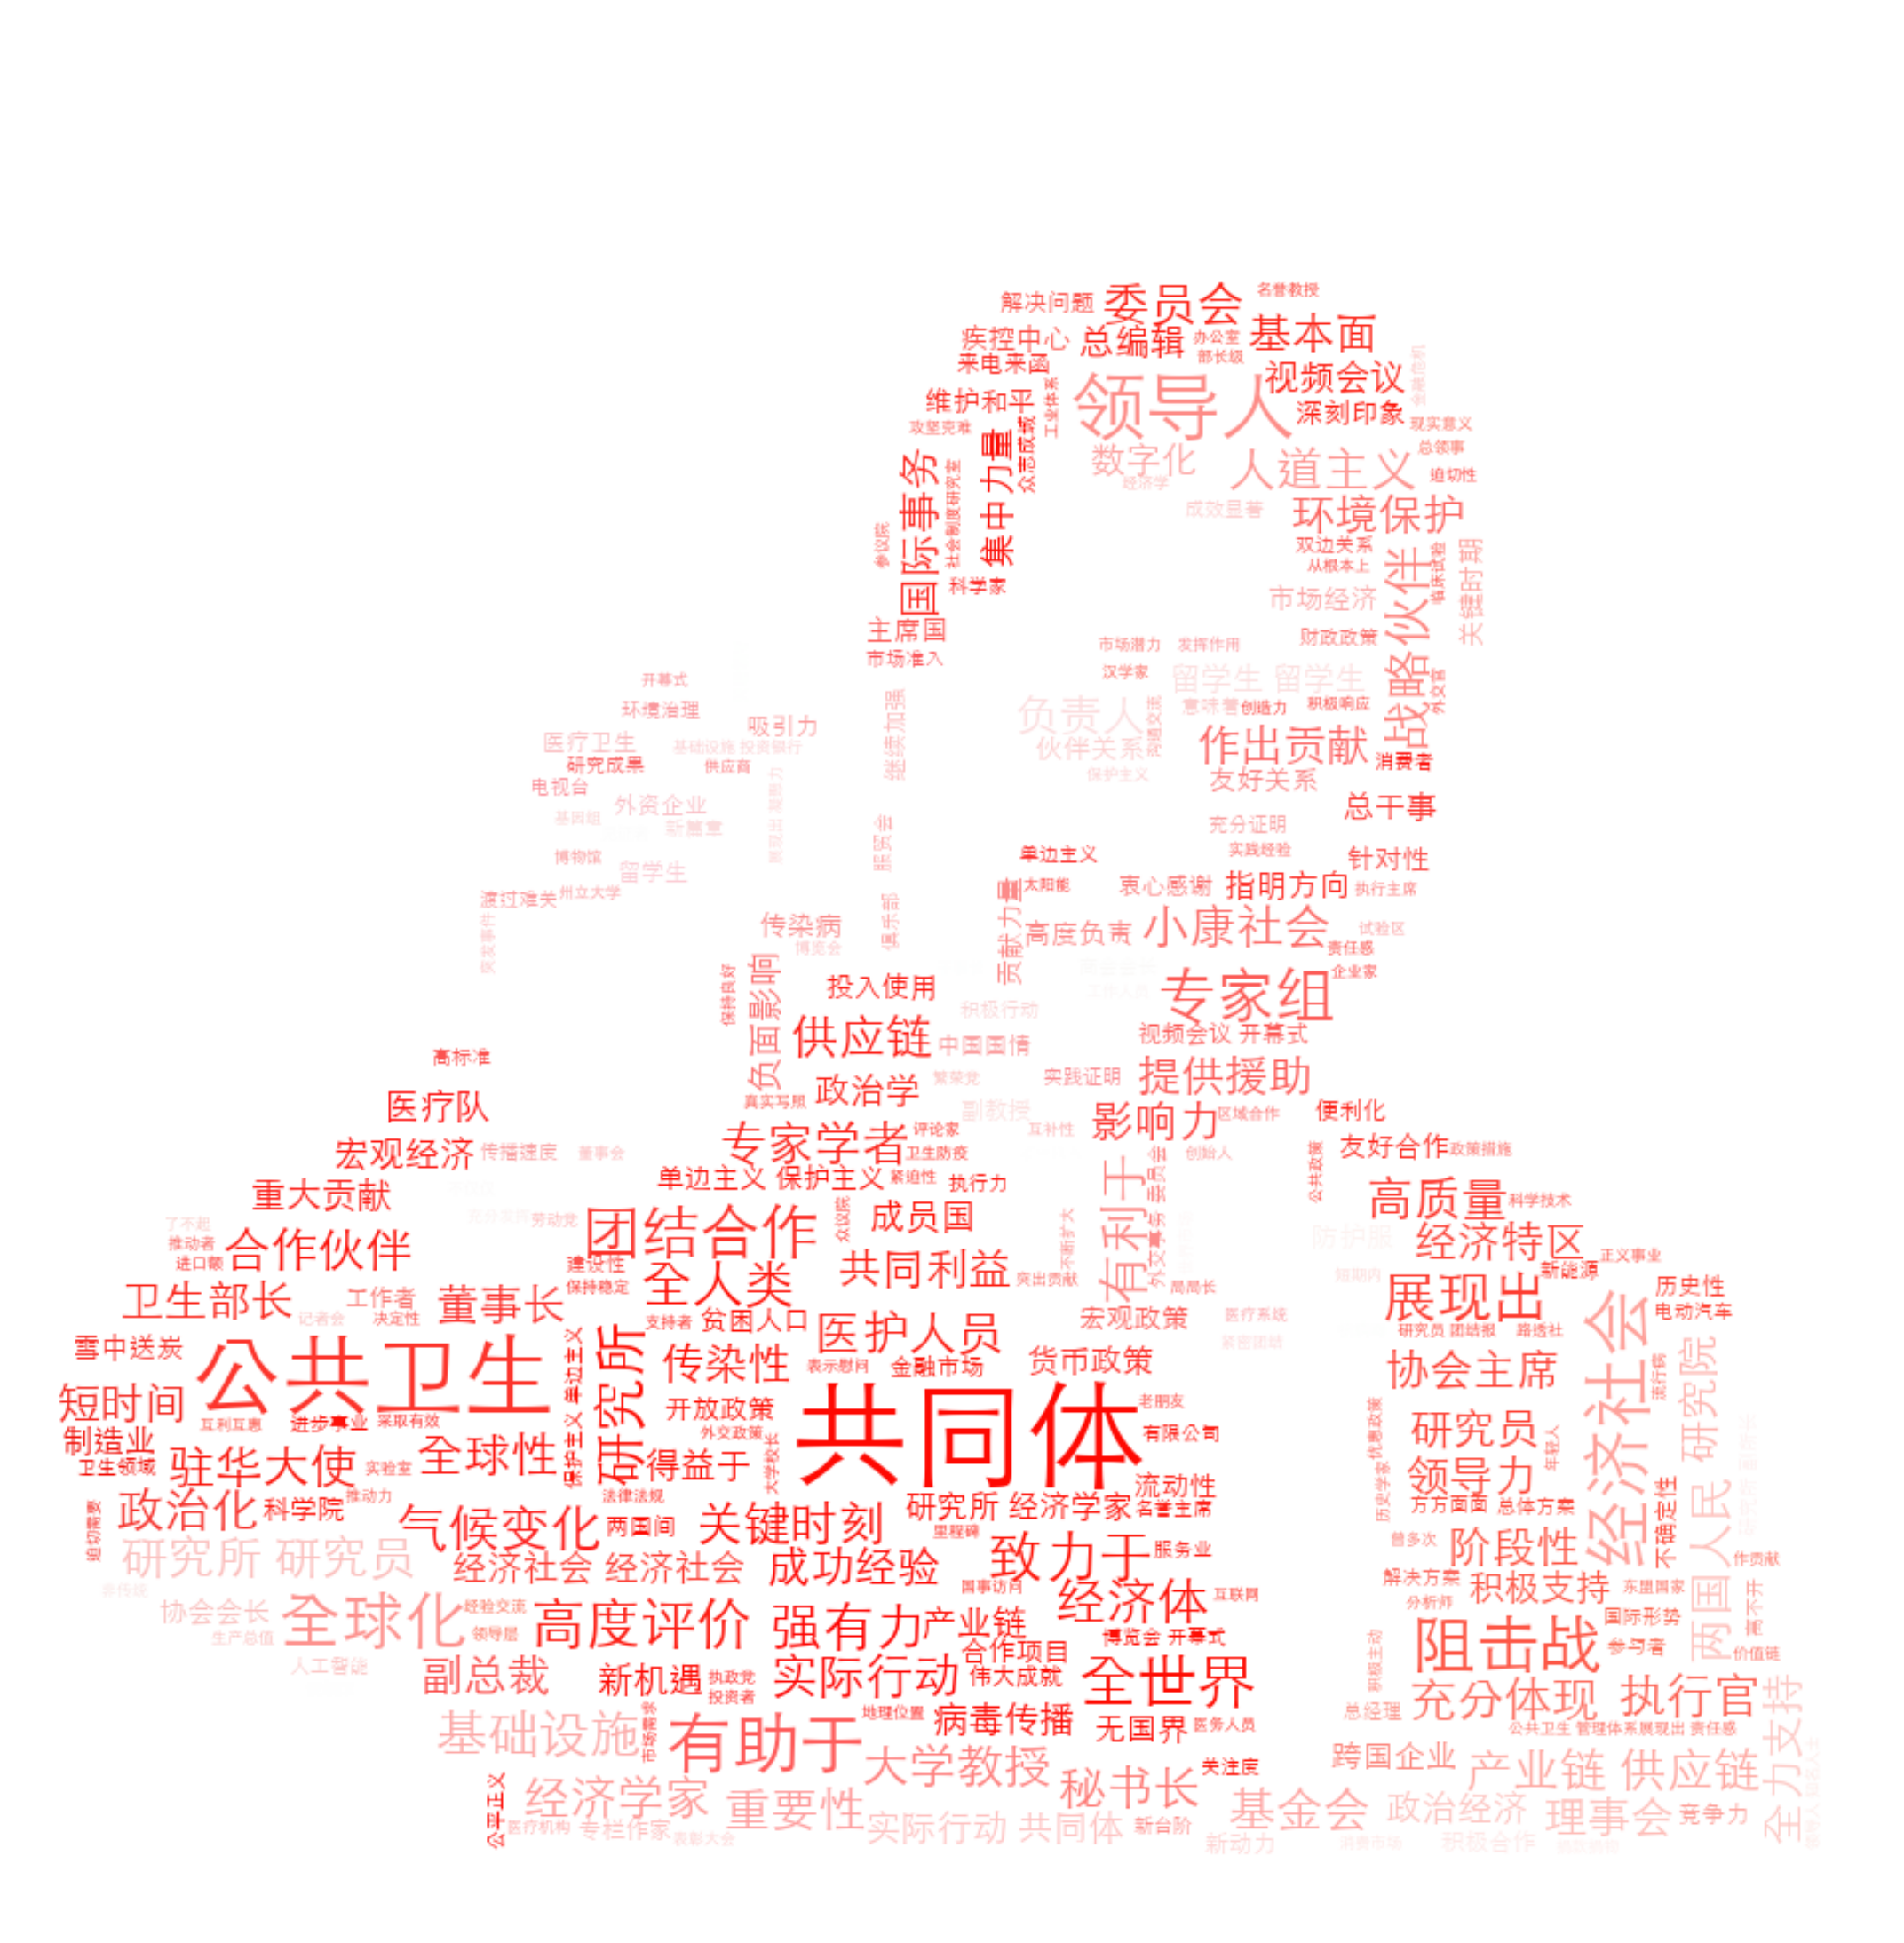

In [40]:
# 过滤一下
words_list = [w for w in words_list if len(w) > 2 and w not in bad_words]
from wordcloud import WordCloud, ImageColorGenerator

# 美化 加载背景图片
from matplotlib.pyplot import imread
bg_pic = imread(r'mask1.jpg')
image_colors = ImageColorGenerator(bg_pic)

'''
指定中文字体和最大词数，设置背景为白色，字体大小20（为了图片细节）
因为背景图片太小了，所以手动设置缩放为2倍
注意之后传入的是一整个文本，如果是数组最后会带'号，不美观。
'''
wordcloud = WordCloud(font_path = '/System/Library/Fonts/STHeiti Light.ttc',
                      max_words=100000,
                      mask=bg_pic,
                      background_color='white',
                      max_font_size=30,
                      scale=2,
                     ).generate(' '.join(words_list))

# 在jupyter中显示图片的魔术方法。
%pylab inline
import matplotlib.pyplot as plt
plt.figure(figsize=(40,40))
plt.imshow(wordcloud.recolor(color_func=image_colors),interpolation="bilinear")
plt.axis("off")